In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
import cv2
import ResnetMultichannel.multichannel_resnet
from ResnetMultichannel.multichannel_resnet import get_arch as Resnet
import pdb

from skmultilearn.model_selection import iterative_train_test_split
from FocalLoss import *

ModuleNotFoundError: No module named 'ResnetMultichannel.multichannel_resnet'

In [3]:
PATH = Path('data')

TRAIN = PATH/'train'
TEST = PATH/'test'
LABELS = PATH/'train.csv'
TEST = PATH/'test'
TEST_CSV = PATH/'sample_submission.csv'

# Data preparation

In [4]:
test_df = pd.read_csv(TEST_CSV)

# Gets complete path/filename for each test sample
test_fnames = [TEST/o for o in test_df['Id']]

# Training data
labels = pd.read_csv(LABELS)
labels.head(), len(labels)

(                                     Id   Target
 0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
 1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
 2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
 3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
 4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18, 31072)

In [5]:
# This splits the label strings in the CSV to lists of integers
Y = np.array([list(map(int, s.split(' '))) for s in labels.Target])

# Get an array of File IDs
X = np.array(list(labels.Id))[:, None]

Creating a one hot encoded vector for all labels

In [6]:
y = np.zeros((len(Y), 28), dtype=int)

for i, label in enumerate(Y):
    for cls in label:
        y[i, cls] = 1

<hr>
Multilabel stratification - train test split that takes care of representing rare classes equally in both <br>
the training and validation sets in a multi label setting

In [7]:
np.random.seed(42)
X_train, Y_train, X_valid, Y_valid = iterative_train_test_split(X, y, 0.15)

In [8]:
def get_label_list_for_data_frame(label):
    return [' '.join(str(i[0]) for i in np.argwhere(label[o])) # gets indices of labels with value=1
              for o in range(len(label))]  # for all elements in Y_train

Get labels in the form a list of strings from a one hot encoded vector

In [9]:
Y_train = get_label_list_for_data_frame(Y_train)
Y_valid = get_label_list_for_data_frame(Y_valid)

Now, we need to create a dataframe for the testing and validation sets <br>
Adding a `Valid` column to the DataFrames to aid in easily splitting the data into training and validation sets

In [10]:
train_df = pd.DataFrame.from_dict(data={'Id':X_train.squeeze(), 'Target': Y_train})
train_df['Valid'] = 0

valid_df = pd.DataFrame.from_dict(data={'Id':X_valid.squeeze(), 'Target': Y_valid})
valid_df['Valid'] = 1

LABELS_DF = pd.concat([train_df, valid_df], axis=0, ignore_index=True)

# Creating Dataset

In [11]:
# Suffixes for image files for each sample (4 channels)
suffixes = ['_red.png', '_green.png', '_blue.png', '_yellow.png']

In [12]:
def open_im_id(ID, path=TRAIN, sufx=suffixes):
    """
    Takes as input the ID of a sample, the `path` to the file
    And `sufx`, a list of all the suffixes for the files of different channels for the training sample
    """
    if str(ID).endswith('.png'):
        ID = str(ID)[:-4]
    else:
        ID = str(ID)
     
    imnames = [ID + o for o in sufx] # Generating file names for given image ID
    imgs = [cv2.imread(o, cv2.IMREAD_GRAYSCALE) for o in imnames]  # List of 4 channels of given file ID
    imgs = np.stack(imgs, 2)
    return Image(pil2tensor(imgs, np.float32).float())  # Creating a Fastai Image object from the image

open_func = partial(open_im_id, path=TRAIN, sufx=suffixes)

In [13]:
classes = """
Nucleoplasm  
Nuclear membrane   
Nucleoli   
Nucleoli fibrillar center   
Nuclear speckles   
Nuclear bodies   
Endoplasmic reticulum   
Golgi apparatus   
Peroxisomes   
Endosomes   
Lysosomes   
Intermediate filaments   
Actin filaments   
Focal adhesion sites   
Microtubules   
Microtubule ends   
Cytokinetic bridge   
Mitotic spindle   
Microtubule organizing center   
Centrosome   
Lipid droplets   
Plasma membrane   
Cell junctions   
Mitochondria   
Aggresome   
Cytosol   
Cytoplasmic bodies   
Rods & rings
"""

classes = classes.split('\n')[1:-1]

In [14]:
class CustomImageList(ImageList):
    def open(self, fn):
        return open_func(fn)
    
    
    # Customizing the function that shows the images to work with 4 channels by creating a new 3 channel Image
    # object every time an Image has to be shown
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, rows, imgsize=imgsize, figsize=figsize)
        for x,y,ax in zip(xs, ys, axs.flatten()):
            Image(x.data[[0,1,2],:,:]).show(ax=ax, y=y,
                                            title=' '.join([classes[o] for o in list(np.argwhere(y.data.numpy()).reshape(-1))]),
                                            **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()

In [15]:
def remove_random_channels(tensor):
        """
        Assumes tensor.shape = [batch_size, channels, height_or_width, height_or_width]
        For each training sample in a batch:
        1. Selects a random number `N` in range (0, number_of_channels)
        2. Sets all values in channel N to zero
        """
        if isinstance(tensor, Image):
            tensor = tensor.data
        num_channels = tensor.shape[0]
        random_channel = 1
        #randomly select a different channel to be ignored for each sample in a batch except the protein channel
        while random_channel == 1:
            random_channel = np.random.randint(0, num_channels)

        #replce selected channels of samples with zeros

        tensor[random_channel] = torch.zeros_like(tensor[random_channel])
        return tensor

def get_custom_transforms():
    """
    Adds a transform to ignore channels in the list of transforms for training and validation data
    """
    tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                          max_lighting=0.05, max_warp=0.3)
#     add_to_tfms = TfmPixel(remove_random_channels)
#     add_to_tfms = RandTransform(add_to_tfms, kwargs={}, p=1.0)
#     tfms[0].append(add_to_tfms)
#     tfms[1].append(add_to_tfms)
#     tfms[0].append(to_half)
#     tfms[1].append(to_half)

    return tfms[0], tfms[1]


# Per channel mean and standard deviation
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [16]:
# np.random.seed(1)
data = (CustomImageList.from_df(LABELS_DF, PATH, folder='train', suffix='.png')
          .split_from_df()
          .label_from_df(label_delim=' ', classes=[str(i) for i in range(28)])
          .add_test(test_fnames, label='0')
          .transform(get_custom_transforms(), size=512)
          .databunch(bs=32)  # bs : batch size
          .normalize(protein_stats)
         )

# data.train_dl.add_tfm(to_half)
# data.valid_dl.add_tfm(to_half)

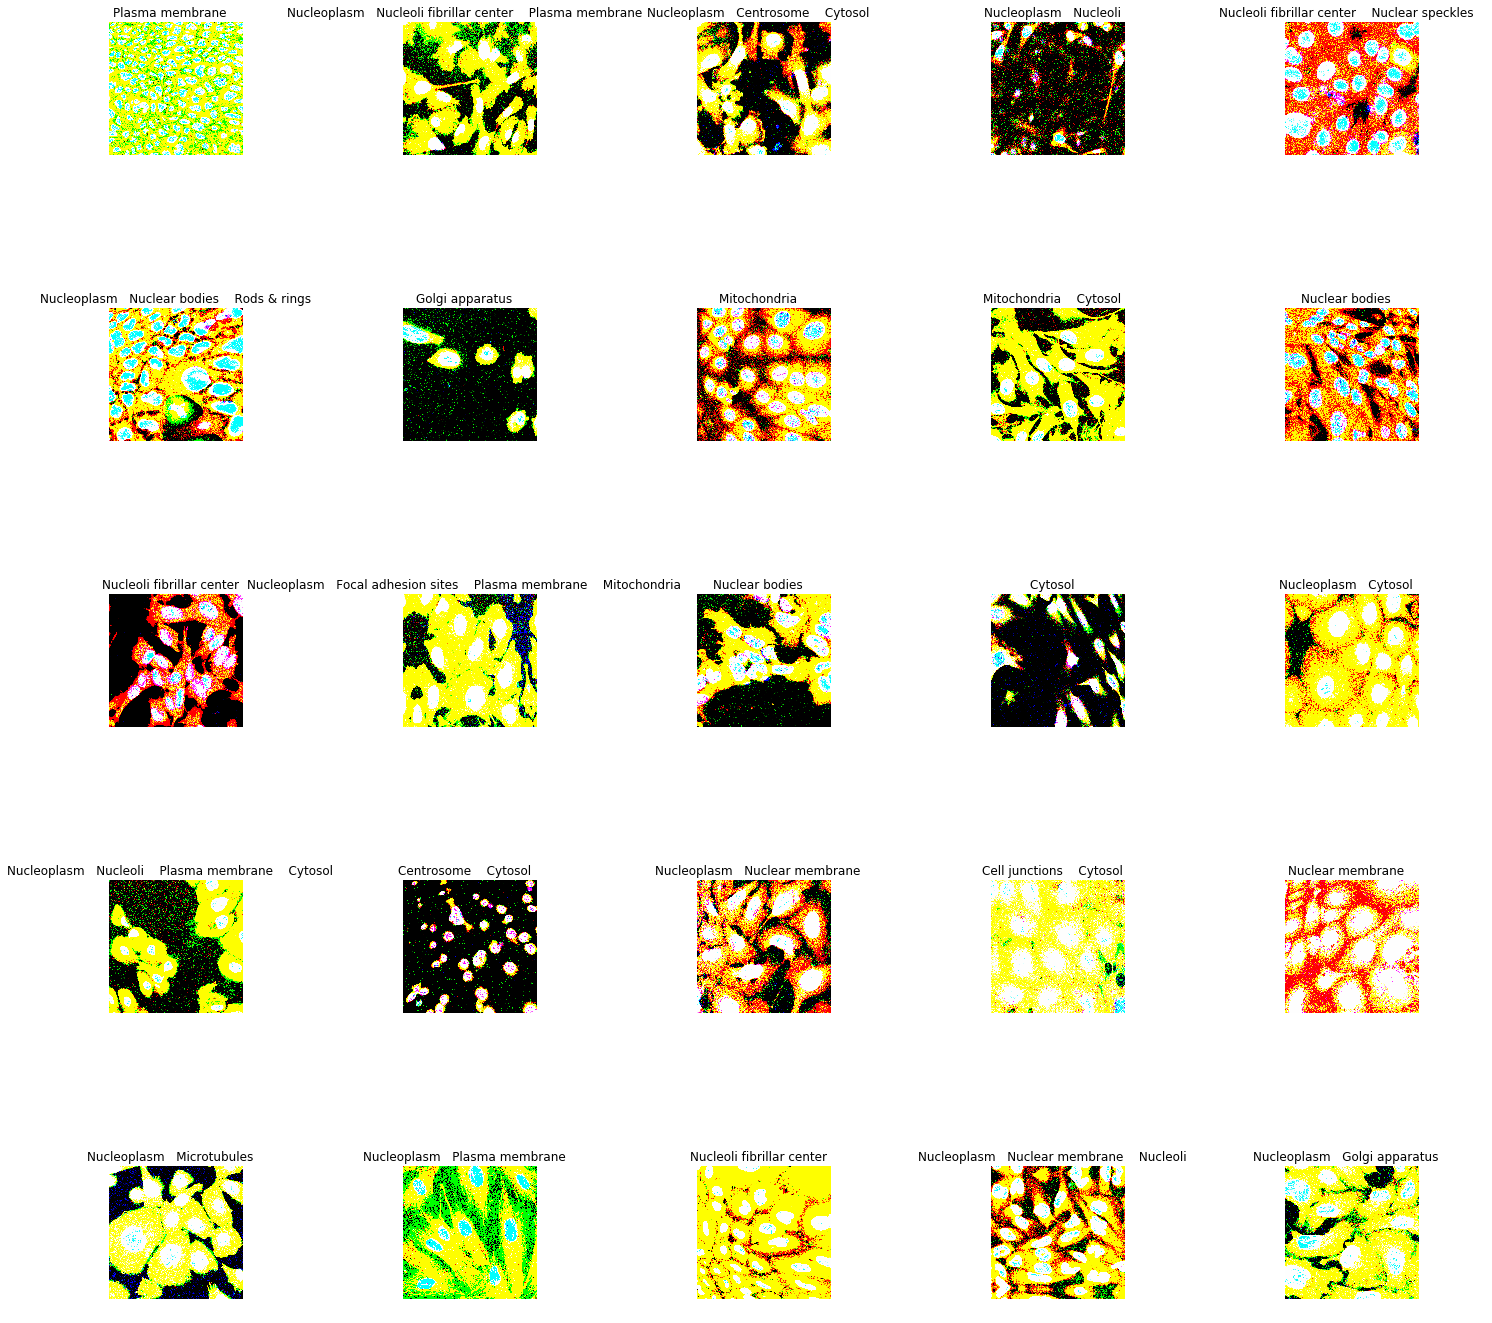

In [17]:
data.show_batch()

# Creating the model

### Setting up losses and metrics

In [18]:
# # Taken From:
# # https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb

# class FocalLoss(nn.Module):
#     def __init__(self, gamma=2):
#         super().__init__()
#         self.gamma = gamma
        
#     def forward(self, input, target):
#         if not (target.size() == input.size()):
#             raise ValueError("Target size ({}) must be the same as input size ({})"
#                              .format(target.size(), input.size()))

#         max_val = (-input).clamp(min=0)
#         loss = input - input * target + max_val + \
#             ((-max_val).exp() + (-input - max_val).exp()).log()

#         invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
#         loss = (invprobs * self.gamma).exp() * loss
        
#         return loss.sum(dim=1).mean()

In [19]:
# Competition Metric
f1_score = partial(fbeta, thresh=0.3, beta=1)
# Accuracy over multiple classes. Each score above `thresh` will be treated as `Correct`
acc = partial(accuracy_thresh, thresh=0.3)

metrics = [acc, f1_score]
loss_function = FocalLoss()

### Creating model object

_Model saving scheme:_ <br>
`SpecialAPPROACH(es)_Architecture_ImageSize_FROZEN?_Epochs`

In [20]:
def save_model(model, approaches, arch, im_size, frozen, epochs):
    """
    Appropriately names and saves the model according to the paramaters
    """
    if isinstance(approaches, list):
        approaches = '-'.join(approaches)
    arch = str(arch)
    im_size = str(im_size)
    if isinstance(frozen, int):
        frozen = 'FreezeTo' + str(frozen)
    else:
        frozen = str(frozen)
    epochs = str(epochs)
    save_str = '_'.join([approaches, arch, im_size, frozen, epochs])
    model.save(save_str)
    print('Model Saved As :', save_str)
    
def load_model(model, approaches, arch, im_size, frozen, epochs):
    """
    Appropriately loads the model according to the given parameters
    """
    if isinstance(approaches, list):
        approaches = '-'.join(approaches)
    arch = str(arch)
    im_size = str(im_size)
    if isinstance(frozen, int):
        frozen = 'FreezeTo' + str(frozen)
    else:
        frozen = str(frozen)
    epochs = str(epochs)
    save_str = '_'.join([approaches, arch, im_size, frozen, epochs])
    model.load(save_str)
    print('Model Loaded from :', save_str)

In [21]:
MODEL_PATH = 'Models_Stratified_4_channel'

# Tells fastai where to form the layer groups
def _resnet_split(m:nn.Module): return (m[0][6],m[1])

In [22]:
resnet50 = Resnet(50, 4)

In [23]:
model = cnn_learner(data, 
                   resnet50,
                   cut=-2,
                   split_on=_resnet_split, 
                   lin_ftrs=[512, 128, 28],
                   ps=0.4,
                   loss_func=loss_function,
                   path=PATH,
                   metrics=metrics,
                   model_dir=MODEL_PATH,
                   callback_fns = [ShowGraph]
                  )

In [37]:
print(model.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 256, 256]       12,544     False     
______________________________________________________________________
BatchNorm2d          [64, 256, 256]       128        True      
______________________________________________________________________
ReLU                 [64, 256, 256]       0          False     
______________________________________________________________________
MaxPool2d            [64, 128, 128]       0          False     
______________________________________________________________________
Conv2d               [64, 128, 128]       36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________

# Begin Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


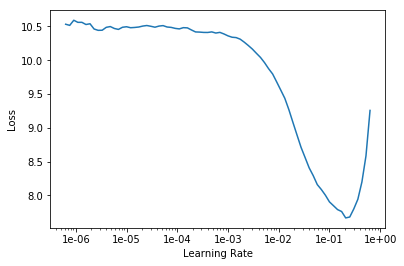

In [192]:
model.lr_find()
model.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,1.315610,1.319489,0.843407,0.310040
2,1.237362,1.245677,0.856652,0.348246


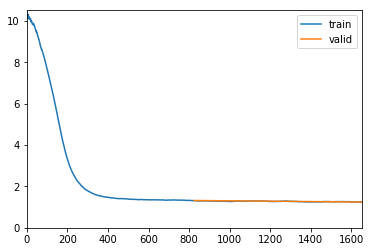

In [81]:
model.fit_one_cycle(2, 1e-2)

In [82]:
save_model(model, ['4_channel', 'stratified', 'focalLoss'], 'resnet50', 512, 'Frozen', 2)

Model Saved As : 4_channel-stratified-focalLoss_resnet50_512_Frozen_2


In [27]:
load_model(model, ['4_channel', 'stratified', 'focalLoss'], 'resnet50', 512, 'Frozen', 2)

Model Loaded from : 4_channel-stratified-focalLoss_resnet50_512_Frozen_2


In [44]:
model.freeze_to(-3)

In [29]:
lr = 5e-3
lrs = slice(lr/10, lr)

In [30]:
model.callback_fns.append(partial(GradientClipping, clip=1.0))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,1.281993,1.328841,0.875085,0.327151
2,1.207961,1.247791,0.857243,0.338277
3,1.202374,1.175879,0.863052,0.365917


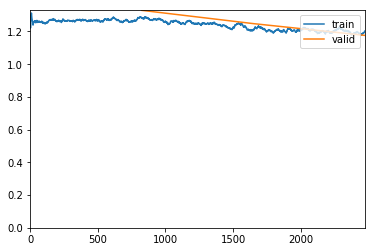

In [31]:
model.fit_one_cycle(3, lrs)

In [32]:
save_model(model, ['4_channel', 'stratified', 'focalLoss'], 'resnet50', 512, -3, 2)

Model Saved As : 4_channel-stratified-focalLoss_resnet50_512_FreezeTo-3_2


In [33]:
load_model(model, ['4_channel', 'stratified', 'focalLoss'], 'resnet50', 512, -3, 2)

Model Loaded from : 4_channel-stratified-focalLoss_resnet50_512_FreezeTo-3_2


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


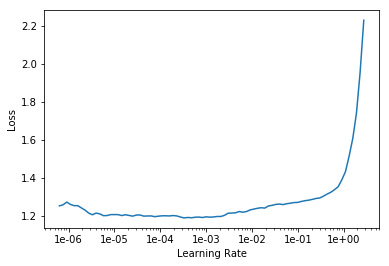

In [34]:
model.lr_find()
model.recorder.plot()

In [37]:
lr = 1e-2
lrs = slice(lr/5, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,1.264600,1.358045,0.872928,0.313900
2,1.205908,1.212602,0.874217,0.358374
3,1.175534,1.157308,0.876343,0.386257


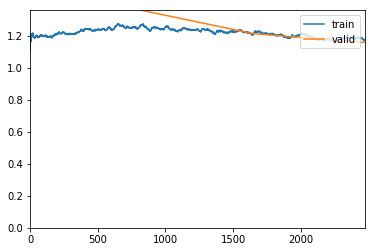

In [38]:
model.fit_one_cycle(3, lrs)

In [45]:
save_model(model, ['4_channel', 'stratified', 'focalLoss'], 'resnet50', 512, -3, 2)

Model Saved As : 4_channel-stratified-focalLoss_resnet50_512_FreezeTo-3_2


In [46]:
load_model(model, ['4_channel', 'stratified', 'focalLoss'], 'resnet50', 512, -3, 2)

Model Loaded from : 4_channel-stratified-focalLoss_resnet50_512_FreezeTo-3_2


In [47]:
model.freeze_to(-7)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


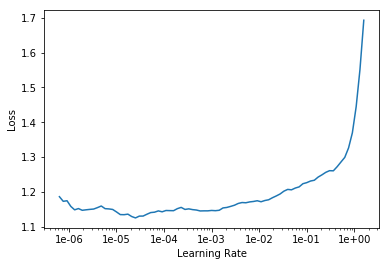

In [40]:
model.lr_find()
model.recorder.plot()

In [48]:
lr = 5e-3
lrs = slice(lr/10, lr)
wd = 1e-3
# wds = slice(wd/20, wd)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,1.187220,1.158153,0.876120,0.384238
2,1.179184,1.149614,0.868017,0.381445
3,1.178869,2.527441,0.878223,0.389650
4,1.174390,2.168198,0.881592,0.404355
5,1.148741,1.703565,0.876903,0.401292


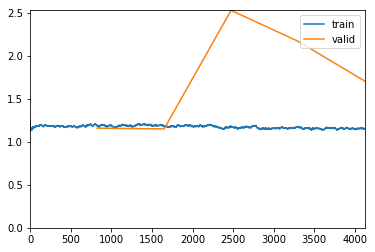

In [49]:
model.fit_one_cycle(5, lrs, wd=wd)

In [50]:
save_model(model, ['stratified', 'focalLoss'], 'resnet50', 512, -7, 9)

Model Saved As : stratified-focalLoss_resnet50_512_FreezeTo-7_9


In [51]:
load_model(model, ['stratified', 'focalLoss'], 'resnet50', 512, -7, 9)

Model Loaded from : stratified-focalLoss_resnet50_512_FreezeTo-7_9


In [52]:
model.unfreeze()
# model.callback_fns.append(partial(GradientClipping, clip=0.6))
# model.lr_find()
# model.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,1.149924,1.470648,0.881699,0.410222
2,1.145375,1.249916,0.877478,0.404517
3,1.147487,1.371407,0.881016,0.412030
4,1.155587,1.922474,0.880855,0.411207
5,1.157495,2.306377,0.879957,0.408524


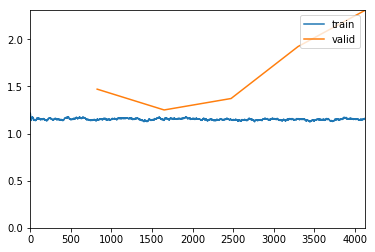

In [53]:
lr = 1e-3
lrs = slice(lr/30, lr)
wd = 1e-3
# wds = slice(wd/20, wd)
model.fit_one_cycle(5, lrs, wd=wd)

In [56]:
save_model(model, ['stratified', 'focalLoss'], 'resnet50', 512, 'unfrozen', 16)

Model Saved As : stratified-focalLoss_resnet50_512_unfrozen_16


In [57]:
load_model(model, ['stratified', 'focalLoss'], 'resnet50', 512, 'unfrozen', 16)

Model Loaded from : stratified-focalLoss_resnet50_512_unfrozen_16


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


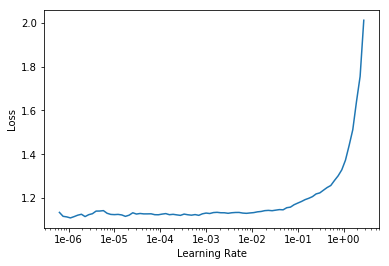

In [58]:
model.lr_find()
model.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,1.149192,1.440893,0.880541,0.409637
2,1.148833,1.606953,0.881945,0.414194
3,1.145562,1.794233,0.882505,0.412164


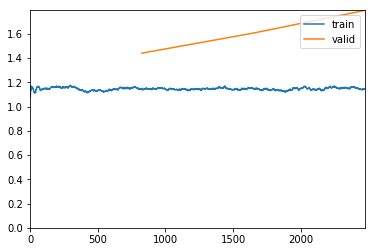

In [59]:
lr = 1e-4
lrs = slice(lr/10, lr)
wd = 4e-3
# wds = slice(wd/20, wd)
model.fit_one_cycle(3, lrs, wd=wd)

In [63]:
save_model(model, ['stratified', 'focalLoss'], 'resnet50', 512, 'unfrozen', 20)

Model Saved As : stratified-focalLoss_resnet50_512_unfrozen_20
Model Loaded from : stratified-focalLoss_resnet50_512_unfrozen_20


In [24]:
load_model(model, ['stratified', 'focalLoss'], 'resnet50', 512, 'unfrozen', 20)

Model Loaded from : stratified-focalLoss_resnet50_512_unfrozen_20


In [25]:
model.export('Sample_model.pkl')

In [26]:
lr = 4e-5
lrs = slice(lr/5, lr)
wd = 1e-2
# wds = slice(wd/20, wd)
model.fit_one_cycle(5, lrs, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


KeyboardInterrupt: 